In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:


class BanditPolicy():
    """
    This is the base/parent policy class, not meant to be used directly.

    We place this at the top of the file so that anyone reading this code in 
    future - including future you - will know that to use any policy class, they
    mainly just need to read this one. Read one thing, and learn most of how
    all the others work. So convenient!!
    """

    # We don't need an init, since this is about the shared methods of choice.

    def argmax_with_random_tiebreaker(self, action_value_estimates):
        """
        Chooses the maximum of the provided action-value estimates,
        with ties broken randomly.

        Args:
            action_value_estimates: A numpy array containing action-value
            estimates.
        Returns:
            The index of the max element.
        """
        return np.random.choice(
            np.where( action_value_estimates == action_value_estimates.max())[0]
        )
    
    def choose_action(self):
        """
        This method is just here to be overridden, so it is 'empty'.
        """
        pass

class BanditEpsilonGreedyPolicy(BanditPolicy):
    """
    The epsilon-greedy action selection policy. An agent following the 
    epsilon-greedy policy will choose a random action with probability epsilon,
    and will greedily choose the best action (argmax) with probability 
    1 - epsilon. If multiple actions are tied for the best choice, ties are
    broken randomly.
    
    Attributes:
        epsilon: A value [0,1] that determines the probability that an agent will
        randomly choose an action at each timestep.
    """
    def __init__(self, epsilon = 0.1):
        self.epsilon = epsilon
    
    def __str__(self):
        return "Epsilon-Greedy Policy: {e}".format(e = self.epsilon)
    
    def choose_action(self, agent_data):
        """
        This is where we override the method that's in the base class.

        Args:
            action_value_estimates: A numpy array containing the action-value
            estimates for a given bandit problem environment.
        Returns:
            action: The index of the chosen action.
        """
        action_value_estimates = agent_data['action_value_estimates']

        roll = random.uniform(0,1)
        
        if roll <= self.epsilon:
            action = random.choice( list( range(0,len(action_value_estimates))))
        else:
            action = self.argmax_with_random_tiebreaker(action_value_estimates)
        return action
    

class BanditUCBPolicy(BanditPolicy):
    """
    EXPLANATION OF UCB GOES HERE
    
    ALSO INCLUDE INPUT / OUTPUT DOCUMENTATION
    """
    def __init__(self, c):
        self.c = c
        self.t = 1

    def __str__(self):
      return "UCB Policy, C = {c}".format(c = self.c)

    def choose_action(self, agent_data):

        """
        How UCB enables exploration?

        UCB define a $bias = c * np.sqrt(np.log(t) / n)$. 
        If the number of an action has been chosen is small, then the bias term got bigger. 
        As the time goes on, it will more likely to encourage the agent to explore on other actions.

        And if we compare to eplison-greedy:
        epsilon-greedy divide the selection process into two phases: Exploration and Exploitation. 
        It will explore with the same probability (epsilon\N) while exploring.
        """
        
        # CODE
        action_value_estimates = agent_data["action_value_estimates"]
        action_counts = agent_data["action_counts"]

        ucb_values = []
        for i, n in enumerate(action_counts):
            if n == 0:
                ucb_values.append(np.inf)
            else:
                ucb_value = action_value_estimates[i] + self.c * np.sqrt(np.log(self.t) / n)
                ucb_values.append(ucb_value)

        ucb_values = np.array(ucb_values)
        # print(ucb_values)
        action = self.argmax_with_random_tiebreaker(ucb_values)
        self.t += 1
        
        return action


class BanditSoftmaxPolicy(BanditPolicy):
    """
    As in equation 2.9 in the text.
    """

    def __str__(self):
        return "Softmax Policy"

    def softmax(self, x):
        probabilities = np.exp(x) / np.sum(np.exp(x), axis = 0)
        return probabilities

    def choose_action(self,agent_data):
        action_value_estimates = agent_data["action_value_estimates"]
        probabilities = self.softmax(action_value_estimates)
        action_choices = range(0,len(action_value_estimates))
        action = random.choices(action_choices, probabilities)[0]
        return action



SyntaxError: (unicode error) 'unicodeescape' codec can't decode bytes in position 496-497: malformed \N character escape (2592831029.py, line 88)

In [ ]:

class BanditEnvironment():
    """
    The K-Armed Bandit. I called this "BanditEnvironment" because the
    environment is the problem the learner agent is trying to solve; it is
    the thing they act upon that gives reward feedback.

    Attributes:
        k: The number of actions ("levers", "arms") in the bandit problem.
        mu: The mean of the normal distribution from which we draw q*, the 
            true action value for each arm. Note that we don't have to draw
            q* from a normal distribution, and might work that into this class
            or a new class if we wanted to.
        sigma: The standard deviation of the above distribution.
        true_action_values: q*, the true action values.
        optimal action: The action index that has the highest q*.
    """

    def __init__(self, k, mu, sigma):
        self.k = k
        self.mu = mu
        self.sigma = sigma
        self.true_action_values = np.random.normal(mu, sigma, k)
        self.optimal_action = np.random.choice(
            np.where(self.true_action_values == self.true_action_values.max())[0]
        )
    
    def reset_true_action_values(self):
        """
        Resets the values of all actions to 0. This is for resets between
        runs, or if you want to see how your learner responds to a "system
        shock" where the dynamics change suddenly. If you want to provide a 
        more serious shock than the BanditEnvironment object's current mu
        and sigma, you can change these manually, e.g.,
        my_bandit_env.mu = 5, etc.
        """
        self.true_action_values = np.random.normal(self.mu, self.sigma, self.k)
        self.optimal_action = np.random.choice(
            np.where(self.true_action_values == self.true_action_values.max())[0]
        )

    def random_walk_action_values(self, mu = 0, sigma = 0.01):
        """
        A method that adds a random value to each element of the true action
        values. 

        This is for part of Assignment 1! (Exercise 2.5 in the text)

        Args:
            mu: The mean of the normal distribution from which the random
                walk value is drawn.
            sigma: The standard deviation of the above distribution.
        """
        draws = np.random.normal(mu,sigma, len(self.true_action_values))
        self.true_action_values += draws
        self.optimal_action = np.random.choice(
            np.where(self.true_action_values == self.true_action_values.max())[0]
        )

    def take_action_emit_reward(self, action):
        """
        Accepts an action index, draws reward from that q* distribution, and
        outputs a reward for that action + whether or not that action was
        optimal.

        Args:
            action: The index of the action to take.
        Returns:
            reward: A scalar (float) reward value.
        """
        return np.random.normal( self.true_action_values[action]), \
            action == self.optimal_action



In [ ]:
class BanditAgent():
    """
    This is a base class that will not be explicitly used in code.

    So far we have learned that there are various ways of estimating q*. We
    focused on the sample average method so far in our coding, but of course
    there are other ways like the gradient bandit algorithm.

    Because agents all have things in common - choosing actions according to
    a policy, action-value estimates, updating, etc. - we can put the common
    factors in this base class or "parent" class, and have the other agent
    classes just inherit. This keeps our code cleaner and more flexible.

    Attributes:
        policy: An instance of the BanditPolicy class set. Used for choosing
                actions.
        bandit_env: An instance of the BanditEnvironment class set. Used for 
            taking actions, setting action-value vectors (i.e., contains k, 
            which we need for initializing q and n).
        initial_estimates: The value used to populate the initial action-value
        estimates vector (usually 0, can be higher for optimistic initial values).

    """

    def __init__(self, policy, bandit_env, initial_estimates = 0):
        self.policy = policy
        self.bandit_env = bandit_env
        self.initial_estimates = initial_estimates # for easy reuse
        self.action_value_estimates = self.initial_estimates * \
            np.ones(self.bandit_env.k)
        self.action_counts = np.zeros(self.bandit_env.k)
    
    def __str__(self):
        """
        It is generally good practice to use the __str__ method to enable
        quick checking of relevant things about a class. Here, we might want to
        check an Agent's policy type and number of actions.
        """
        return "Policy: {policy}, K = {k}".format(
            policy = self.policy.__str__(), 
            k = self.bandit_env.k
        )
    
    def reset_action_value_estimates(self, new_initial_estimates = None):
        """
        Resets the agent's action-value estimates and counts their initially
        chose estimate (usualy 0), or to a new initial estimate passed as an
        argument. All agents will need this, so we can put it here.
        
        Args:
            new_initial_estimates: A value that will replace the attribute
                initial_estimates in the reset.
        """
        pass
    
    def choose_action(self):
        """
        Chooses an action to take against the environment. All agents will be
        doing this, so we put it in the base/parent class.

        Returns:
            An action index.
        """
        agent_data = {
            "action_value_estimates" : self.action_value_estimates,
            "action_counts" : self.action_counts
        }
        action = self.policy.choose_action(agent_data)
        return action



class SampleAverageBanditAgent(BanditAgent): # Note the inheritance
    """
    A basic sample-average based bandit learner.

    Note that because we included all the basic methods in the base class,
    we do not need to repeat ourselves here. Much cleaner! All we need to do
    is override the update_action_value_estimates function and we're done!
    """
    def reset_action_value_estimates(self, new_initial_estimates = None):
        if new_initial_estimates is not None:
            self.action_value_estimates[:] = new_initial_estimates
        else:
            self.action_value_estimates[:] = self.initial_estimates
        self.action_counts[:] = 0

    def update_action_value_estimates(self, action, reward):
        """
        Our basic sample-average incremental update, where the learning rate
        is 1 / N(A)
        
        Args:
            action: The index of the action to have its count and action-value
            estimate updated.
            reward: The reward received as a result of choosing the action above
            that is used in the update equation. 
        """
        self.action_counts[action] += 1
        learning_rate = 1 / self.action_counts[action]
        self.action_value_estimates[action] += learning_rate * \
            (reward - self.action_value_estimates[action])




In [ ]:
class BanditTestRunner():
    """
    This class object is the tool that runs our experiments and then visualizes
    the results. We feed it ONE bandit environment, and one or more agents
    that will attempt to solve that environment.

    Note that in Figure 2.2 in the text, they use 1000 timesteps and average
    over 2000 runs.

    Attributes:
        agents: One or more agents from the BanditAgent class set.
        num_agents: The number of agents.
        bandit_env: The BanditEnvironment object - the specific bandit problem
            for this set of tests.
    """

    def __init__(self, agents, bandit_env):
        self.agents = agents
        self.num_agents = len(agents)
        self.bandit_env = bandit_env

    def full_reset(self):
        """
        Resets all true action values in the bandit environment, and resets
        all action-value estimates and counts in the agents.
        """
        self.bandit_env.reset_true_action_values()
        for agent in self.agents:
            agent.reset_action_value_estimates()
        
    def perform_runs(self, timesteps = 1000, runs = 2000, walk = None):
        """
        Performs experiments in which the agent(s) attempt to learn the 
        bandit.

        Args:
            timesteps: The number of timesteps each agent has to learn the
                        bandit within each run.
            runs: The number of runs to conduct and average over.
        """
        # One history per agent
        rewards_history = np.zeros( (timesteps, len(self.agents)))
        optimal_action_history = np.zeros_like(rewards_history)

        for run in tqdm( range(0, runs) ):
            self.full_reset()
            
            for timestep in range(0,timesteps):
                
                for agent_id, agent in enumerate(self.agents):
                    
                    # Choose your action
                    action = agent.choose_action()
                    
                    # Act on the environment, receive reward signal.
                    reward, optimal = self.bandit_env.\
                        take_action_emit_reward(action)
                    
                    # Use action and reward to update Q value.
                    agent.update_action_value_estimates(action, reward)
                    
                    # Record reward and boolean for optimal choice, for later visualization.
                    rewards_history[timestep, agent_id] += reward
                    if optimal:
                        optimal_action_history[timestep,agent_id] += 1
                    if walk is not None:
                        self.bandit_env.random_walk_action_values(walk[0],walk[1])
                
                
        return rewards_history / runs, optimal_action_history / runs

    def visualize_results(self, save_filename, title, rewards_histories,
        optimal_action_histories): 
        # To label our plots, we reference our list of agents.
        # Our history objects will also be in this order.
        # So we can call the policy __str__ function to label our plot.
        labels = []
        for agent in self.agents:
            labels.append(agent.policy.__str__())

        plt.figure(figsize=[16,12])
        
        plt.subplot(2,1,1)
        plt.plot(optimal_action_histories*100)
        print(optimal_action_histories)
        print(optimal_action_histories*100)
        plt.ylim(0,100)
        plt.xlabel("Steps")
        plt.ylabel("% Optimal Action Chosen")
        plt.xticks( np.arange(0, len(rewards_histories), len(rewards_histories)/10) )
        plt.tick_params(axis='x')
        plt.tick_params(axis='y')
        plt.legend(labels)
        
        plt.subplot(2,1,2)
        plt.plot(rewards_histories)
        plt.ylabel("Average Reward")
        plt.xticks( np.arange(0, len(rewards_histories),len(rewards_histories)/10) )
        plt.tick_params(axis='x')
        plt.tick_params(axis='y')
        plt.legend(labels)
        plt.show

        if save_filename is not None:
            plt.savefig(save_filename)    

100%|██████████| 2000/2000 [24:14<00:00,  1.38it/s]


[[0.098  0.1045 0.096  0.107  0.1065 0.1105]
 [0.1355 0.1095 0.0965 0.0985 0.1085 0.103 ]
 [0.171  0.0975 0.0985 0.101  0.097  0.1015]
 ...
 [0.7955 0.912  0.866  0.816  0.7405 0.714 ]
 [0.801  0.912  0.8725 0.8075 0.761  0.716 ]
 [0.804  0.9095 0.868  0.7995 0.76   0.719 ]]
[[ 9.8  10.45  9.6  10.7  10.65 11.05]
 [13.55 10.95  9.65  9.85 10.85 10.3 ]
 [17.1   9.75  9.85 10.1   9.7  10.15]
 ...
 [79.55 91.2  86.6  81.6  74.05 71.4 ]
 [80.1  91.2  87.25 80.75 76.1  71.6 ]
 [80.4  90.95 86.8  79.95 76.   71.9 ]]


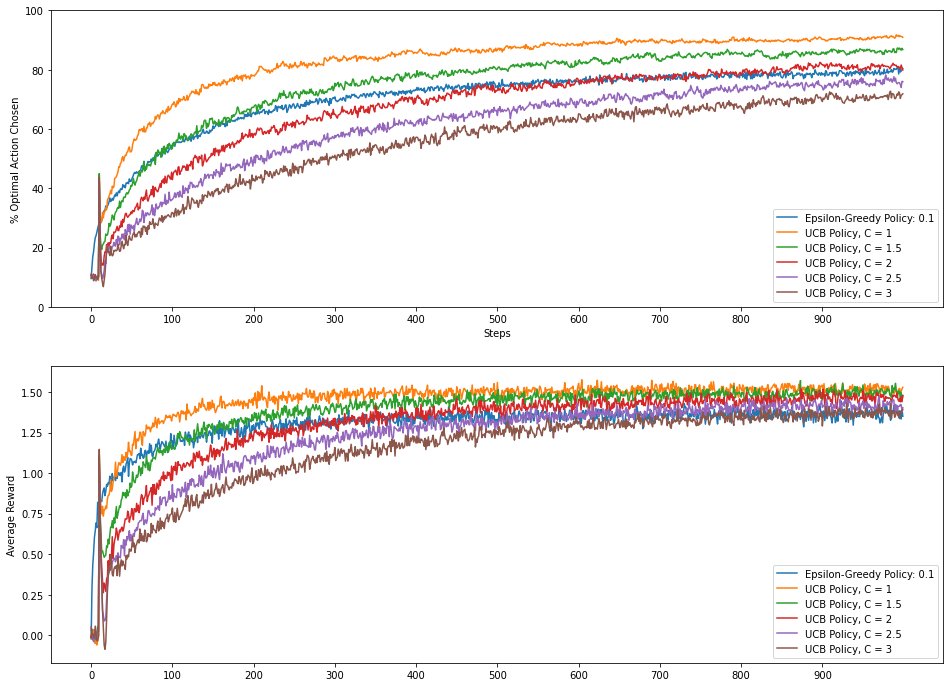

In [15]:
bandit = BanditEnvironment(k = 10, mu = 0, sigma = 1)

egreedy_10perc = BanditEpsilonGreedyPolicy()
egreedy_1perc = BanditEpsilonGreedyPolicy(epsilon = 0.01)
### initialize a UCB policy
ucb_1perc = BanditUCBPolicy(c = 1)
ucb_1_5perc = BanditUCBPolicy(c = 1.5)
ucb_2perc = BanditUCBPolicy(c = 2)
ucb_2_5perc = BanditUCBPolicy(c = 2.5)
ucb_3perc = BanditUCBPolicy(c = 3)
ucb_3_5perc = BanditUCBPolicy(c = 3.5)
ucb_4perc = BanditUCBPolicy(c = 4)
ucb_5perc = BanditUCBPolicy(c = 5)


agent1 = SampleAverageBanditAgent(policy = egreedy_10perc, bandit_env = bandit)
agent2 = SampleAverageBanditAgent(policy = egreedy_1perc, bandit_env = bandit)
### Initialize SampleAverageBanditAgent and give it the UCB policy
agent3 = SampleAverageBanditAgent(policy = ucb_1perc, bandit_env = bandit)
agent4 = SampleAverageBanditAgent(policy = ucb_1_5perc, bandit_env = bandit)
agent5 = SampleAverageBanditAgent(policy = ucb_2perc, bandit_env = bandit)
agent6 = SampleAverageBanditAgent(policy = ucb_2_5perc, bandit_env = bandit)
agent7 = SampleAverageBanditAgent(policy = ucb_3perc, bandit_env = bandit)

agents = [agent1, agent3, agent4, agent5, agent6, agent7]

runner = BanditTestRunner(agents = agents, bandit_env = bandit)

# Note how long it takes to perform the runs - very good case for parallelization!
r, o = runner.perform_runs(timesteps = 1000, runs = 2000)

### edit title
runner.visualize_results(
    save_filename = None,
        title = "Epsilon-Greedy 10% vs. Epsilon-Greedy 1%", 
        rewards_histories = r, 
        optimal_action_histories = o
        )


In [16]:
r, o = runner.perform_runs(timesteps = 10000, runs = 1000, walk = [0,0.01])

runner.visualize_results(
    save_filename = None,
        title = "Epsilon-Greedy 10% vs. UCB C=2 for Random Walk N(0,0.01)", 
        rewards_histories = r, 
        optimal_action_histories = o
        )

 11%|█         | 112/1000 [17:33<3:02:28, 12.33s/it]